In [ ]:
#En este ejemplo implementaremos el algoritmo de detección de anomalías y lo aplicaremos para detectar fallas en servidores
#de una red. Este dataset solo comprende 2 dimensiones.

#Los atributos del dataset son el rendimiento(mb/s) y la latencia(ms) de respuesta de cada servidor.

#Utilizaremos un modelo Gaussiano para detectar observaciones anómalas en el dataset.

In [101]:
#Configuración de tamaño de gráficos
options(repr.plot.width=5, repr.plot.height=4, scipen = 99)

In [111]:
#Instalación y carga de paquetes necesarios
list.of.packages <- c('ggplot2', 'R.matlab', 'ggthemes', 'AtmRay')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)
library(R.matlab)
library(ggthemes)
library(AtmRay)

package 'AtmRay' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Administrator\AppData\Local\Temp\Rtmp0cAhrs\downloaded_packages


In [103]:
#Carga de datos
X <- as.data.frame(readMat('ex8data1.mat'))

str(X)
head(X)

Xval <- data.frame(Xval.1 = X$Xval.1, Xval.2 = X$Xval.2)
yval <- X$yval
X <- X[,1:2]

str(Xval)
str(yval)
str(X)

'data.frame':	307 obs. of  5 variables:
 $ X.1   : num  13 13.4 14.2 14.9 13.6 ...
 $ X.2   : num  14.7 13.8 15.9 16.2 14 ...
 $ Xval.1: num  15.8 13.6 14.9 13.6 13.5 ...
 $ Xval.2: num  14.9 15.3 16.5 14 15.6 ...
 $ yval  : num  0 0 0 0 0 0 0 0 0 1 ...


X.1,X.2,Xval.1,Xval.2,yval
13.04682,14.74115,15.79026,14.92102,0
13.40852,13.76327,13.63962,15.32996,0
14.19591,15.85318,14.86590,16.47387,0
14.91470,16.17426,13.58468,13.98931,0
13.57670,14.04285,13.46404,15.63533,0
13.92240,13.40647,12.94889,16.14007,0


'data.frame':	307 obs. of  2 variables:
 $ Xval.1: num  15.8 13.6 14.9 13.6 13.5 ...
 $ Xval.2: num  14.9 15.3 16.5 14 15.6 ...
 num [1:307] 0 0 0 0 0 0 0 0 0 1 ...
'data.frame':	307 obs. of  2 variables:
 $ X.1: num  13 13.4 14.2 14.9 13.6 ...
 $ X.2: num  14.7 13.8 15.9 16.2 14 ...


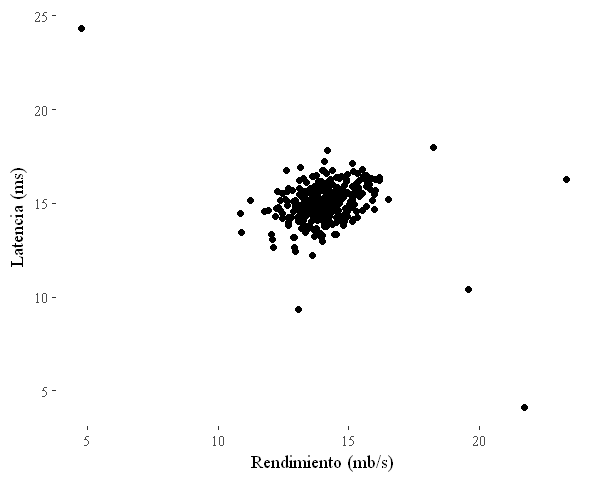

In [104]:
#Visualizamos los datos
ggplot(data = X, aes(x = X.1, y = X.2)) + geom_point() + xlab('Rendimiento (mb/s)') + ylab('Latencia (ms)') + theme_tufte()

In [105]:
#Ahora tenemos que estimar un modelo Gaussiano para cada uno de los atributos, es decir, debemos encontrar los parámetros
#mu y sigma cuadrado para cada modelo (promedio y varianza)

estimateGaussian <- function(X) {
    
    m <- nrow(X)
    n <- ncol(X)
    mu <- rep(0, n)
    sigma2 <- rep(0, n)
    mu <- colMeans(X)
    sigma2 <- apply(X, 2, var)
    
    return(list(mu = mu, sigma2 = sigma2))
}

results <- estimateGaussian(X)
mu <- results$mu
sigma2 <- results$sigma2

mu
sigma2

X.1      X.2 
14.11223 14.99771

X.1      X.2 
1.838620 1.715333

In [231]:
#Calculamos la densidad de la normal multivariada de cada observación en X

multivariateGaussian <- function(X, mu, Sigma2) {
    
    k <- length(mu)
    
    if(is.vector(Sigma2)) {
        Sigma2 <- diag(Sigma2)
    }
    
    X <- as.matrix(X)
    
    X <- sweep(X, MARGIN=2, mu, FUN="-")
    p <- (2 * pi) ^ (- k / 2) * det(Sigma2) ^ (-0.5) * (exp(-0.5 * rowSums((X %*% solve(Sigma2)) * X)))
    
    return(p)
}

p <- multivariateGaussian(X, mu, sigma2)

Warning message in sweep(X, MARGIN = 2, mu, FUN = "-"):
"STATS does not recycle exactly across MARGIN"

ERROR: Error in X %*% solve(Sigma2): argumentos no compatibles


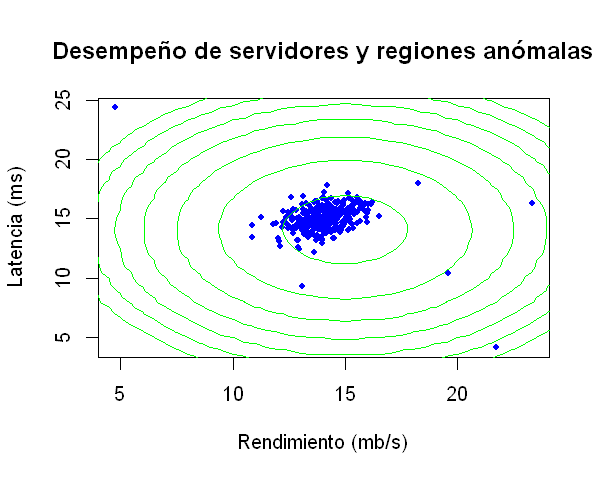

In [232]:
#Visualizamos las gráficas de contorno para la distribución Gaussiana ajustada.
plotOutliers <- function() {
    
    xy_seq <- seq(0, 35, 0.5)
    mg <- meshgrid(xy_seq, xy_seq)
    X1 <- c(mg$x)
    X2 <- c(mg$y)

    Z <- multivariateGaussian(cbind(X1, X2), mu, sigma2)
    Z <- matrix(Z, length(xy_seq), length(xy_seq))

    plot(X[,1], X[,2], col = 'blue', xlab = 'Rendimiento (mb/s)', ylab = 'Latencia (ms)', pch = 20, 
         main = 'Desempeño de servidores y regiones anómalas')
    if (sum(is.infinite(Z)) == 0) {
        contour(xy_seq, xy_seq, Z, levels = 10 ^ t(seq(-20,0,3)) ,add = TRUE, drawlabels = FALSE, col = "green")
    }
}

plotOutliers()

In [233]:
#Selección del umbral Epsilon

#Ahora que estimamos los parámetros Gaussianos buscaremos las observaciones que tienen una probabilidad alta dada esta
#distribucion y cuales tienen una probabilidad más baja (las anomalías). Para ello utilizaremos el F1-score sobre un test
#de validación.

pval <- multivariateGaussian(Xval, mu, sigma2)

selectTreshold <- function(yval, pval) {
    
    bestEpsilon <- 0
    bestF1 <- 0
    F1 <- 0
    
    stepsize <- (max(pval) - min(pval)) / 1000
    
    for(epsilon in seq(min(pval),max(pval),stepsize)) {
        
        predictions <- as.integer(pval < epsilon)
        
        TP <- sum((yval == 1) & (predictions == 1))
        FN <- sum((yval == 1) & (predictions == 0))
        FP <- sum((yval == 0) & (predictions == 1))
        
        precision <- TP / (TP + FP) 
        recall <- TP / (TP + FN)
        
        F1 <- 2 * precision * recall / (precision + recall)
        
        if (!is.na(F1) && F1 > bestF1) {
            
            bestF1 <- F1
            bestEpsilon <- epsilon
        }
    }
    
    return(list(epsilon = bestEpsilon, F1 = bestF1))
}

results <- selectTreshold(yval, pval)
epsilon <- results$epsilon
F1 <- results$F1

cat('Mejor Epsilon encontrado usando el set de validación: ', epsilon)
cat('\nMejor F1 en el set de validación: ', F1)

Mejor Epsilon encontrado usando el set de validación:  0.00008961568
Mejor F1 en el set de validación:  0.875

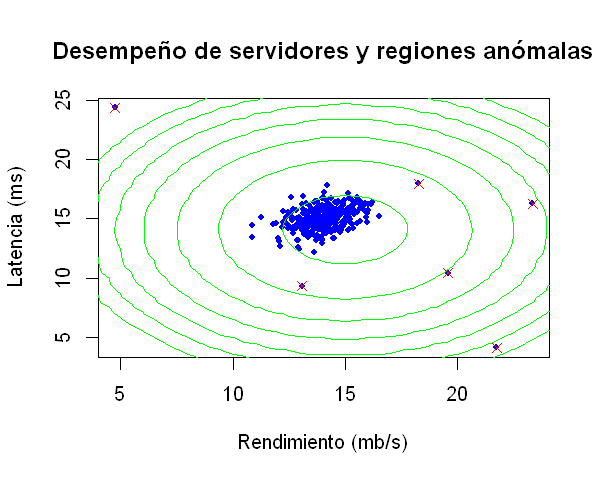

In [234]:
#Detectamos los outliers y volvemos a graficar
outliers <- which((p < epsilon) %in% TRUE)
plotOutliers()
points(X[outliers, 1], X[outliers, 2], pch = 4, col = 'red')